In [1]:
import praw
import pandas as pd
import re
import emoji
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# === Reddit API Setup ===
reddit = praw.Reddit(
    client_id='q_dYyqYYdNNInGsM-lC9Xg',
    client_secret='pLigWA6vX6llH7NjWBhVWmg-gJjKvg',
    user_agent='script:gaming_trend (by /u/HiGhastlyy)'
)

In [59]:
# === Base game to subreddit variants mapping ===
GAME_SUBREDDITS = {
    "Genshin Impact": ["genshin_impact", "GenshinImpact"],
    "Valorant": ["valorant", "ValorantCompetitive"],
    "GTA": ["GTA", "GTAOnline", "GTA6", "GrandTheftAutoV", "GTAV", "GTAV_Mods"],
    "League of Legends": ["leagueoflegends", "summonerschool", "LeagueConnect"],
    "Gaming": ["gaming", "pcgaming", "Games", "Gamers"],
    "Call Of Duty": ["CallOfDuty", "CODWarzone", "CODMobile"],
    "Minecraft":  ['Minecraft','minecraftsuggestions','MinecraftDungeons','MinecraftServer'],
    "The Sims" : ['thesims','Sims4','TheSimsBuilding','Sims3', 'thesims4'],
    "Overwatch" : ['Overwatch', 'OverwatchLeague', 'Competitiveoverwatch', 'Competitiveoverwatch'],
    "Skyrim": ['skyrim', 'skyrimmods', 'SkyrimModsXbox', 'kyrimTogether']
}

In [43]:
# === Text cleaning ===
def clean_text(text):
    if not text:
        return ""
    text = text.encode("ascii", errors="ignore").decode()
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# === Bot Detection ===
def is_suspected_bot(posts, threshold=5):
    duplicates = defaultdict(int)
    for p in posts:
        key = (p['author'], p['cleaned'])
        duplicates[key] += 1
    return {author for (author, _), count in duplicates.items() if count >= threshold}


In [ ]:
def scrape_game_posts(game_name, subreddit_list, start_year=2020, end_year=2025, year_cap=200):
    print(f"\nScraping for '{game_name}'...")
    year_counts = defaultdict(int)
    collected = []

    def try_add(post, sub):
        if post.stickied or not post.title:
            return False

        created = datetime.utcfromtimestamp(post.created_utc)
        year = created.year
        if year < start_year or year > end_year:
            return False

        if year_counts[year] >= year_cap:
            return False

        cleaned_title = clean_text(post.title)
        if len(cleaned_title) < 10:
            return False

        post_data = {
            'game': game_name,
            'subreddit': sub,
            'author': str(post.author),
            'created_utc': created.isoformat(),
            'year': year,
            'score': post.score,
            'original_title': post.title,
            'cleaned': cleaned_title
        }

        key = (post_data['author'], post_data['original_title'], year)
        if key in seen:
            return False

        collected.append(post_data)
        seen.add(key)
        year_counts[year] += 1
        return True

    seen = set()

    for sub in subreddit_list:
        subreddit = reddit.subreddit(sub)
        print(f"  ➤ Scanning r/{sub}")

        MODES = [
            ("top", subreddit.top(limit=1000, time_filter="all")),
            ("new", subreddit.new(limit=1000)),
            ("hot", subreddit.hot(limit=1000)),
            ("rising", subreddit.rising(limit=250)),
        ]

        for mode_name, post_iter in MODES:
            if all(year_counts[y] >= year_cap for y in range(start_year, end_year + 1)):
                break  # Exit if all years are filled

            print(f"     → Trying .{mode_name}()")
            for post in tqdm(post_iter, desc=f"{sub} [{mode_name}]"):
                if all(year_counts[y] >= year_cap for y in range(start_year, end_year + 1)):
                    break
                try_add(post, sub)

    # Log any underfilled years
    for y in range(start_year, end_year + 1):
        if year_counts[y] < year_cap:
            print(f"⚠️  [{game_name}] Year {y} only has {year_counts[y]} posts")

    return collected


In [48]:
# === Run scraper across all games ===
all_posts = []

for game, subs in GAME_SUBREDDITS.items():
    all_posts.extend(scrape_game_posts(game, subs, year_cap=200))

# === Filter out bot-like users ===
bot_users = is_suspected_bot(all_posts)
filtered_posts = [p for p in all_posts if p['author'] not in bot_users]


Scraping for 'Genshin Impact'...
  ➤ Scanning r/genshin_impact
     → Trying .top()


genshin_impact [top]: 0it [00:00, ?it/s]C:\Users\Ghastly\AppData\Local\Temp\ipykernel_24096\1315138358.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  created = datetime.utcfromtimestamp(post.created_utc)
genshin_impact [top]: 999it [00:23, 43.38it/s]


     → Trying .new()


genshin_impact [new]: 992it [00:21, 46.50it/s]


     → Trying .hot()


genshin_impact [hot]: 500it [00:10, 49.49it/s]


     → Trying .rising()


genshin_impact [rising]: 27it [00:00, 27.94it/s]


  ➤ Scanning r/GenshinImpact
     → Trying .top()


GenshinImpact [top]: 988it [00:16, 60.92it/s]


     → Trying .new()


GenshinImpact [new]: 989it [00:17, 57.57it/s]


     → Trying .hot()


GenshinImpact [hot]: 500it [00:07, 65.14it/s]


     → Trying .rising()


GenshinImpact [rising]: 25it [00:00, 51.40it/s]


⚠️  [Genshin Impact] Year 2020 only has 147 posts
⚠️  [Genshin Impact] Year 2022 only has 117 posts
⚠️  [Genshin Impact] Year 2023 only has 90 posts

Scraping for 'Valorant'...
  ➤ Scanning r/valorant
     → Trying .top()


valorant [top]: 985it [00:19, 50.66it/s]


     → Trying .new()


valorant [new]: 956it [00:15, 62.07it/s]


     → Trying .hot()


valorant [hot]: 500it [00:08, 56.24it/s]


     → Trying .rising()


valorant [rising]: 25it [00:00, 46.21it/s]


  ➤ Scanning r/ValorantCompetitive
     → Trying .top()


ValorantCompetitive [top]: 900it [00:20, 44.88it/s]


     → Trying .new()


ValorantCompetitive [new]: 983it [00:21, 44.94it/s]


     → Trying .hot()


ValorantCompetitive [hot]: 500it [00:10, 46.00it/s]


     → Trying .rising()


ValorantCompetitive [rising]: 25it [00:00, 50.53it/s]


⚠️  [Valorant] Year 2023 only has 185 posts
⚠️  [Valorant] Year 2024 only has 165 posts

Scraping for 'Dota 2'...
  ➤ Scanning r/DotA2
     → Trying .top()


DotA2 [top]: 985it [00:18, 53.07it/s]


     → Trying .new()


DotA2 [new]: 950it [00:16, 58.21it/s]


     → Trying .hot()


DotA2 [hot]: 500it [00:08, 62.07it/s]


     → Trying .rising()


DotA2 [rising]: 25it [00:00, 56.20it/s]


  ➤ Scanning r/TrueDoTA2
     → Trying .top()


TrueDoTA2 [top]: 1000it [00:17, 58.59it/s]


     → Trying .new()


TrueDoTA2 [new]: 924it [00:12, 71.45it/s]


     → Trying .hot()


TrueDoTA2 [hot]: 500it [00:08, 58.43it/s]


     → Trying .rising()


TrueDoTA2 [rising]: 25it [00:00, 53.79it/s]


⚠️  [Dota 2] Year 2022 only has 114 posts
⚠️  [Dota 2] Year 2023 only has 64 posts

Scraping for 'League of Legends'...
  ➤ Scanning r/leagueoflegends
     → Trying .top()


leagueoflegends [top]: 987it [00:20, 47.25it/s]


     → Trying .new()


leagueoflegends [new]: 955it [00:14, 64.75it/s]


     → Trying .hot()


leagueoflegends [hot]: 500it [00:09, 52.53it/s]


     → Trying .rising()


leagueoflegends [rising]: 25it [00:00, 30.23it/s]


  ➤ Scanning r/summonerschool
     → Trying .top()


summonerschool [top]: 990it [00:20, 48.75it/s]


     → Trying .new()


summonerschool [new]: 965it [00:16, 58.65it/s]


     → Trying .hot()


summonerschool [hot]: 500it [00:07, 65.82it/s]


     → Trying .rising()


summonerschool [rising]: 25it [00:00, 52.00it/s]


⚠️  [League of Legends] Year 2022 only has 127 posts
⚠️  [League of Legends] Year 2023 only has 23 posts
⚠️  [League of Legends] Year 2024 only has 11 posts

Scraping for 'Gaming'...
  ➤ Scanning r/gaming
     → Trying .top()


gaming [top]: 995it [00:18, 54.12it/s]


     → Trying .new()


gaming [new]: 898it [00:14, 61.31it/s]


     → Trying .hot()


gaming [hot]: 500it [00:10, 49.35it/s]


     → Trying .rising()


gaming [rising]: 26it [00:00, 56.75it/s]


  ➤ Scanning r/pcgaming
     → Trying .top()


pcgaming [top]: 996it [00:19, 52.26it/s]


     → Trying .new()


pcgaming [new]: 927it [00:15, 60.92it/s]


     → Trying .hot()


pcgaming [hot]: 214it [00:06, 34.77it/s]


     → Trying .rising()


pcgaming [rising]: 25it [00:00, 38.47it/s]


  ➤ Scanning r/Games
     → Trying .top()


Games [top]: 1000it [00:17, 55.56it/s]


     → Trying .new()


Games [new]: 825it [00:11, 70.49it/s]


     → Trying .hot()


Games [hot]: 367it [00:07, 50.43it/s]


     → Trying .rising()


Games [rising]: 26it [00:00, 67.47it/s]


⚠️  [Gaming] Year 2023 only has 138 posts
⚠️  [Gaming] Year 2024 only has 64 posts

Scraping for 'Call Of Duty'...
  ➤ Scanning r/CallOfDuty
     → Trying .top()


CallOfDuty [top]: 987it [00:19, 49.49it/s]


     → Trying .new()


CallOfDuty [new]: 973it [00:18, 52.51it/s]


     → Trying .hot()


CallOfDuty [hot]: 269it [00:08, 31.58it/s]


     → Trying .rising()


CallOfDuty [rising]: 25it [00:00, 50.15it/s]


  ➤ Scanning r/CODWarzone
     → Trying .top()


CODWarzone [top]: 998it [00:19, 52.23it/s]


     → Trying .new()


CODWarzone [new]: 981it [00:17, 57.45it/s]


     → Trying .hot()


CODWarzone [hot]: 500it [00:08, 62.09it/s]


     → Trying .rising()


CODWarzone [rising]: 25it [00:00, 53.65it/s]


  ➤ Scanning r/CODMobile
     → Trying .top()


CODMobile [top]: 996it [00:18, 53.74it/s]


     → Trying .new()


CODMobile [new]: 797it [00:13, 60.32it/s]


     → Trying .hot()


CODMobile [hot]: 500it [00:07, 64.62it/s]


     → Trying .rising()


CODMobile [rising]: 24it [00:00, 33.77it/s]


⚠️  [Call Of Duty] Year 2022 only has 156 posts
⚠️  [Call Of Duty] Year 2023 only has 91 posts
⚠️  [Call Of Duty] Year 2024 only has 99 posts

Scraping for 'Minecraft'...
  ➤ Scanning r/Minecraft
     → Trying .top()


Minecraft [top]: 987it [00:19, 49.38it/s]


     → Trying .new()


Minecraft [new]: 950it [00:17, 53.02it/s]


     → Trying .hot()


Minecraft [hot]: 500it [00:09, 50.55it/s]


     → Trying .rising()


Minecraft [rising]: 25it [00:00, 40.62it/s]


  ➤ Scanning r/minecraftsuggestions
     → Trying .top()


minecraftsuggestions [top]: 996it [00:19, 50.02it/s]


     → Trying .new()


minecraftsuggestions [new]: 955it [00:18, 50.91it/s]


     → Trying .hot()


minecraftsuggestions [hot]: 500it [00:10, 46.97it/s]


     → Trying .rising()


minecraftsuggestions [rising]: 24it [00:00, 41.39it/s]


  ➤ Scanning r/MinecraftDungeons
     → Trying .top()


MinecraftDungeons [top]: 999it [00:18, 55.32it/s]


     → Trying .new()


MinecraftDungeons [new]: 990it [00:19, 49.81it/s]


     → Trying .hot()


MinecraftDungeons [hot]: 500it [00:10, 46.73it/s]


     → Trying .rising()


MinecraftDungeons [rising]: 25it [00:00, 39.28it/s]


  ➤ Scanning r/MinecraftServer
     → Trying .top()


MinecraftServer [top]: 1000it [00:23, 42.25it/s]


     → Trying .new()


MinecraftServer [new]: 969it [00:17, 53.87it/s]


     → Trying .hot()


MinecraftServer [hot]: 500it [00:09, 51.47it/s]


     → Trying .rising()


MinecraftServer [rising]: 25it [00:00, 51.74it/s]


⚠️  [Minecraft] Year 2023 only has 65 posts
⚠️  [Minecraft] Year 2024 only has 96 posts

Scraping for 'The Sims'...
  ➤ Scanning r/thesims
     → Trying .top()


thesims [top]: 1000it [00:20, 47.85it/s]


     → Trying .new()


thesims [new]: 996it [00:24, 40.67it/s]


     → Trying .hot()


thesims [hot]: 500it [00:12, 40.38it/s]


     → Trying .rising()


thesims [rising]: 26it [00:00, 40.78it/s]


  ➤ Scanning r/Sims4
     → Trying .top()


Sims4 [top]: 1000it [00:22, 43.70it/s]


     → Trying .new()


Sims4 [new]: 988it [00:27, 35.87it/s]


     → Trying .hot()


Sims4 [hot]: 427it [00:13, 31.40it/s]


     → Trying .rising()


Sims4 [rising]: 25it [00:00, 29.07it/s]


  ➤ Scanning r/TheSimsBuilding
     → Trying .top()


TheSimsBuilding [top]: 482it [00:25, 19.05it/s]


  ➤ Scanning r/Sims3
  ➤ Scanning r/thesims4

Scraping for 'Overwatch'...
  ➤ Scanning r/Overwatch
     → Trying .top()


Overwatch [top]: 995it [00:18, 54.27it/s]


     → Trying .new()


Overwatch [new]: 992it [00:17, 56.18it/s]


     → Trying .hot()


Overwatch [hot]: 500it [00:10, 47.49it/s]


     → Trying .rising()


Overwatch [rising]: 25it [00:00, 32.60it/s]


  ➤ Scanning r/OverwatchLeague
     → Trying .top()


OverwatchLeague [top]: 998it [00:19, 50.53it/s]


     → Trying .new()


OverwatchLeague [new]: 967it [00:19, 48.77it/s]


     → Trying .hot()


OverwatchLeague [hot]: 500it [00:09, 51.61it/s]


     → Trying .rising()


OverwatchLeague [rising]: 25it [00:00, 46.44it/s]


  ➤ Scanning r/Competitiveoverwatch
     → Trying .top()


Competitiveoverwatch [top]: 999it [00:19, 51.14it/s]


     → Trying .new()


Competitiveoverwatch [new]: 991it [00:17, 55.57it/s]


     → Trying .hot()


Competitiveoverwatch [hot]: 500it [00:08, 57.19it/s]


     → Trying .rising()


Competitiveoverwatch [rising]: 25it [00:00, 50.76it/s]


  ➤ Scanning r/Competitiveoverwatch
     → Trying .top()


Competitiveoverwatch [top]: 999it [00:19, 50.79it/s]


     → Trying .new()


Competitiveoverwatch [new]: 991it [00:18, 54.30it/s]


     → Trying .hot()


Competitiveoverwatch [hot]: 500it [00:09, 50.88it/s]


     → Trying .rising()


Competitiveoverwatch [rising]: 25it [00:00, 34.88it/s]


⚠️  [Overwatch] Year 2024 only has 87 posts

Scraping for 'Skyrim'...
  ➤ Scanning r/skyrim
     → Trying .top()


skyrim [top]: 989it [00:20, 47.90it/s]


     → Trying .new()


skyrim [new]: 992it [00:18, 53.60it/s]


     → Trying .hot()


skyrim [hot]: 500it [00:08, 56.45it/s]


     → Trying .rising()


skyrim [rising]: 25it [00:00, 31.48it/s]


  ➤ Scanning r/skyrimmods
     → Trying .top()


skyrimmods [top]: 995it [00:19, 50.91it/s]


     → Trying .new()


skyrimmods [new]: 991it [00:14, 70.21it/s]


     → Trying .hot()


skyrimmods [hot]: 500it [00:07, 65.09it/s]


     → Trying .rising()


skyrimmods [rising]: 25it [00:00, 50.03it/s]


  ➤ Scanning r/SkyrimModsXbox
     → Trying .top()


SkyrimModsXbox [top]: 530it [00:29, 17.73it/s]

  ➤ Scanning r/kyrimTogether


In [61]:
gta_posts = scrape_game_posts("GTA", GAME_SUBREDDITS["GTA"],  year_cap=200)


Scraping for 'GTA'...
  ➤ Scanning r/GTA
     → Trying .top()


GTA [top]: 0it [00:00, ?it/s]C:\Users\Ghastly\AppData\Local\Temp\ipykernel_24096\1315138358.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  created = datetime.utcfromtimestamp(post.created_utc)
GTA [top]: 983it [00:33, 29.29it/s]


     → Trying .new()


GTA [new]: 966it [00:15, 61.88it/s]


     → Trying .hot()


GTA [hot]: 500it [00:08, 59.41it/s]


     → Trying .rising()


GTA [rising]: 25it [00:00, 52.27it/s]


  ➤ Scanning r/GTAOnline
     → Trying .top()


GTAOnline [top]: 998it [00:19, 50.67it/s]


     → Trying .new()


GTAOnline [new]: 985it [00:20, 47.81it/s]


     → Trying .hot()


GTAOnline [hot]: 500it [00:10, 45.77it/s]


     → Trying .rising()


GTAOnline [rising]: 25it [00:00, 41.16it/s]


  ➤ Scanning r/GTA6
     → Trying .top()


GTA6 [top]: 983it [00:23, 42.57it/s]


     → Trying .new()


GTA6 [new]: 952it [00:22, 41.80it/s]


     → Trying .hot()


GTA6 [hot]: 484it [00:12, 37.36it/s]


     → Trying .rising()


GTA6 [rising]: 25it [00:00, 46.70it/s]


  ➤ Scanning r/GrandTheftAutoV
     → Trying .top()


GrandTheftAutoV [top]: 998it [00:15, 64.23it/s]


     → Trying .new()


GrandTheftAutoV [new]: 971it [00:18, 53.19it/s]


     → Trying .hot()


GrandTheftAutoV [hot]: 500it [00:09, 54.70it/s]


     → Trying .rising()


GrandTheftAutoV [rising]: 25it [00:00, 39.93it/s]


  ➤ Scanning r/GTAV
     → Trying .top()


GTAV [top]: 957it [00:19, 49.91it/s]

  ➤ Scanning r/GTAV_Mods


In [1]:
# === Deduplicate and save ===
df = pd.DataFrame(filtered_posts)
df = df.drop_duplicates(subset=["game", "author", "original_title"])



NameError: name 'pd' is not defined

In [73]:
# === Save to CSV ===
df.to_csv("reddit_game_titles_by_year1.csv", index=False)
print(f"\n✅ Saved {len(df)} posts across all games. Bots removed, titles cleaned, capped per year.")


✅ Saved 11437 posts across all games. Bots removed, titles cleaned, capped per year.


In [74]:
# Load the saved CSV
file_path = "reddit_game_titles_by_year1.csv"
df = pd.read_csv(file_path)

In [75]:
# Group by game and year
game_year_counts = df.groupby(["game", "year"]).size().unstack(fill_value=0)

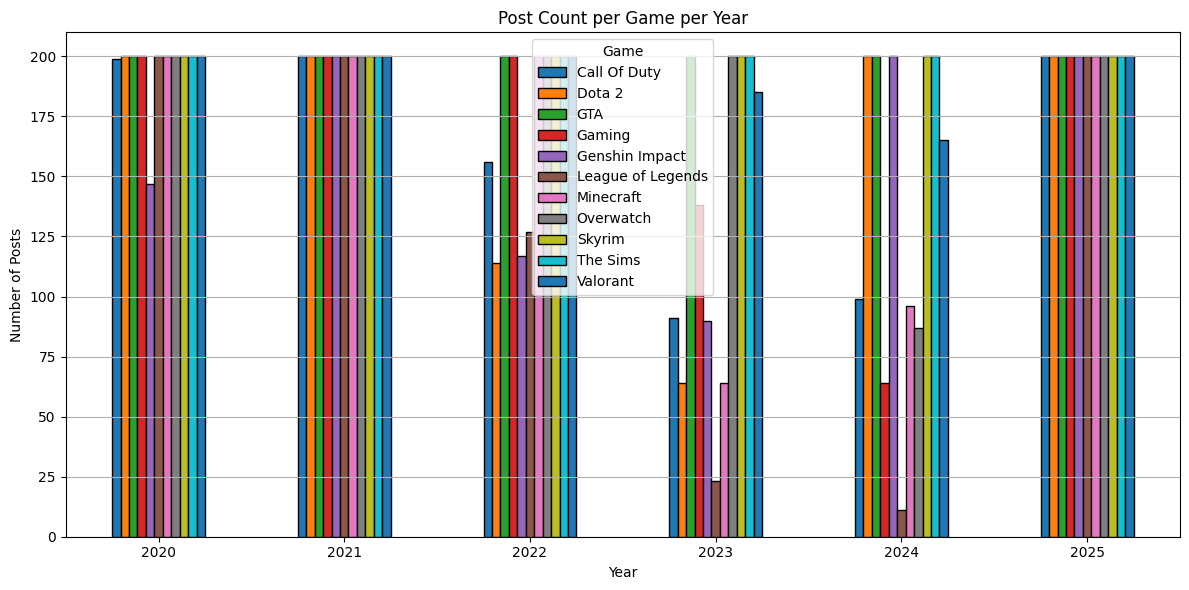

In [76]:
# Plot
game_year_counts.T.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title("Post Count per Game per Year")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.legend(title="Game")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()